In [105]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis
from tqdm import tqdm

In [175]:
import warnings

# Suppress all FutureWarnings coming from statsmodels.tsa.stattools
warnings.filterwarnings(
    "ignore",
    category=FutureWarning,
    module="statsmodels\\.tsa\\.stattools"
)

from statsmodels.tools.sm_exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)


In [107]:
macro_df = pd.read_csv('combined_series.csv', low_memory=False)
loan_df = pd.read_csv('adjusted_index.csv')

In [108]:
# Step 1: Ensure both datasets have datetime columns
loan_df['MONTHLY REPORTING PERIOD'] = pd.to_datetime(loan_df['MONTHLY REPORTING PERIOD'])
macro_df['date'] = pd.to_datetime(macro_df['date'])  # or use macro_df['MONTH'] if that's your column

# Step 2: Standardize date column name for clean merge
loan_df = loan_df.rename(columns={'MONTHLY REPORTING PERIOD': 'date'})

# Step 3: Inner join on DATE
combined_df = pd.merge(loan_df, macro_df, how='inner', on='date')
#combined_df = combined_df.loc[:, combined_df.isnull().mean() <= 0.05]

# Preview the result
combined_df.head()

,Unnamed: 0,date,CURRENT ACTUAL UPB,CURRENT LOAN DELINQUENCY STATUS,LOAN AGE,REMAINING MONTHS TO LEGAL MATURITY,CURRENT INTEREST RATE,CURRENT NON-INTEREST BEARING UPB,INTEREST BEARING UPB,CREDIT SCORE,...,WTP30F41,WTP3HA32,WTP5A10,WTP5A15,WTP5A16,WTP5L02,WVSTHPI,WVUCSFRCONDOSMSAMID,WYSTHPI,WYUCSFRCONDOSMSAMID
0,1,1999-02-01,112441.199684,0.000789,0.037096,305.131018,6.773796,0.0,112441.199684,719.219667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,1999-03-01,113412.587413,0.004060,0.729754,293.458380,6.768129,0.0,113412.587413,717.961617,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,1999-04-01,114278.517002,0.004208,1.211759,291.105084,6.788090,0.0,114278.517002,716.272351,...,NaN,NaN,NaN,NaN,NaN,NaN,146.56,NaN,145.81,NaN
3,4,1999-05-01,112182.876615,0.005253,1.573903,284.366534,6.820286,0.0,112182.876615,714.795948,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,1999-06-01,113042.581068,0.005732,2.053390,287.292827,6.857330,0.0,113042.581068,713.722262,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [109]:
combined_df.iloc[:, 30:] = combined_df.iloc[:, 30:].apply(pd.to_numeric, errors='coerce')
combined_df.iloc[:, 30:] = combined_df.iloc[:, 30:].astype(float)
combined_df = combined_df.loc[:, combined_df.isnull().mean() <= 0.05]
combined_df.iloc[:, 30:] = combined_df.iloc[:, 30:].ffill().bfill()
combined_df.iloc[:, 30:] = (combined_df.iloc[:, 30:] - combined_df.iloc[:, 30:].mean()) / combined_df.iloc[:, 30:].std()

In [133]:
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis
from statsmodels.tsa.stattools import adfuller, grangercausalitytests

# === 0. Load your data ===
# combined_df = pd.read_csv('your_combined.csv', parse_dates=['MONTHLY REPORTING PERIOD'])
# For this snippet we assume it's already in memory.

# === 1. Stationarity Helpers ===
def is_stationary(series, signif=0.05):
    """Return True if the series passes an ADF test at the given significance."""
    series_clean = pd.to_numeric(series, errors='coerce').dropna()
    if len(series_clean) < 10:
        return False
    pval = adfuller(series_clean, autolag='AIC')[1]
    return pval < signif

def ensure_stationary(series):
    """If non-stationary, return first-difference; else return original."""
    s = pd.to_numeric(series, errors='coerce')
    if is_stationary(s):
        return s
    else:
        # first difference
        return s.diff().dropna()

# === 2. Early-Warning Metrics ===
def early_warning_stats(x, y, max_lag, horizon, thresh):
    x, y = ensure_stationary(x), ensure_stationary(y)
    ccs = []
    for lag in range(0, max_lag+1):
        ys = y.shift(lag)
        valid = x.notna() & ys.notna()
        a, b = x[valid].values, ys[valid].values
        ccs.append(np.corrcoef(a, b)[0,1] if len(a)>2 else np.nan)
    ccs = np.array(ccs)
    
    # compute metrics
    corr_at_horz    = ccs[horizon] if horizon<=max_lag else np.nan
    max_corr_early  = np.nanmax(np.abs(ccs[horizon:]))
    above = np.where(np.abs(ccs)>=thresh)[0]
    lag_first = int(above[-1]) if above.size else np.nan
    area_early = np.nansum(np.abs(ccs[horizon:]))
    # Granger causality
    try:
        df_gc = pd.concat([y, x], axis=1).dropna().iloc[:, :2]
        gc = grangercausalitytests(df_gc, maxlag=horizon, verbose=False)
        pval = gc[horizon][0]['ssr_ftest'][1]
    except:
        pval = np.nan

    return {
        'corr_at_horizon':        corr_at_horz,
        'max_corr_early':         max_corr_early,
        'lag_of_first_threshold': lag_first,
        'area_early_window':      area_early,
        'granger_pvalue':         pval
    }

# === 3. Legacy CCF & Spectral Stats ===
def legacy_ccf_stats(x, y, max_lag, freq_resolution):
    x, y = ensure_stationary(x), ensure_stationary(y)
    corrs = []
    for lag in range(0, max_lag+1):
        ys = y.shift(lag)
        valid = x.notna() & ys.notna()
        a, b = x[valid].values, ys[valid].values
        corrs.append(np.corrcoef(a, b)[0,1] if len(a)>2 else np.nan)
    corrs = np.array(corrs)
    
    max_abs_corr     = np.nanmax(np.abs(corrs))
    lag_max_abs      = int(np.nanargmax(np.abs(corrs)))
    centeredness_idx = lag_max_abs / max_lag
    # spectral
    fft_vals = np.fft.rfft(corrs)
    power    = np.abs(fft_vals)**2
    power_norm = power / np.nansum(power)
    freqs    = np.fft.rfftfreq(len(corrs), d=freq_resolution)
    dominant_freq    = freqs[np.nanargmax(power_norm)]
    spectral_entropy = -np.nansum(power_norm * np.log2(power_norm + 1e-12))
    
    return {
        'max_abs_corr':       max_abs_corr,
        'centeredness_index': centeredness_idx,
        'dominant_freq':      dominant_freq,
        'spectral_entropy':   spectral_entropy
    }

# === 4. Apply to All Features ===
# Define your target and predictors
y = combined_df.iloc[:, 30]      # single loan-market risk metric
X = combined_df.iloc[:, 31:]     # macro indices

# Parameters
max_lag         = 36    # months
horizon         = 12
threshold       = 0.1
freq_resolution = 1/12  # cycles per year (monthly spacing)

rows = []
for feat in tqdm(X.columns):
    x_ser = X[feat]
    ew = early_warning_stats(x_ser, y, max_lag, horizon, threshold)
    lg = legacy_ccf_stats(x_ser, y, max_lag, freq_resolution)
    ew.update(lg)
    ew['feature'] = feat
    rows.append(ew)

meta = pd.DataFrame(rows).set_index('feature')

100%|████████████████████████████████████████████████████████████████████████████████| 448/448 [00:32<00:00, 13.94it/s]


In [134]:
meta

,corr_at_horizon,max_corr_early,lag_of_first_threshold,area_early_window,granger_pvalue,max_abs_corr,centeredness_index,dominant_freq,spectral_entropy
feature,,,,,,,,,
AKUCSFRCONDOSMSAMID,0.010039,0.104826,33.0,0.998316,0.979082,0.104826,0.916667,0.648649,3.477653
ALUCSFRCONDOSMSAMID,-0.035079,0.055675,NaN,0.662786,0.994219,0.055675,1.000000,0.324324,2.793499
APU0000701111,-0.101556,0.161922,34.0,1.180579,0.749871,0.161922,0.944444,0.972973,3.498637
APU0000701322,-0.033824,0.117046,36.0,1.202348,0.311013,0.153202,0.000000,4.864865,3.438421
APU0000702111,-0.068003,0.141943,20.0,1.042665,0.056223,0.141943,0.555556,5.513514,3.534495
...,...,...,...,...,...,...,...,...,...
WDXRNSA,-0.017731,0.121590,19.0,1.320848,0.064133,0.121590,0.527778,0.972973,2.307865
WDXRPSNSA,-0.028185,0.095270,NaN,1.270700,0.201227,0.095270,0.944444,0.972973,1.556886
WDXRSA,0.002591,0.106358,28.0,0.955484,0.090218,0.106358,0.777778,0.000000,3.178413


In [171]:
# === 5. Soft‐Thresholded Combined Score (no hard mask) ===
import numpy as np

# Threshold parameters
corr_thresh    = 0.05    # minimum horizon correlation
early_thresh   = 0.10    # minimum early peak correlation
pval_thresh    = 0.50    # maximum acceptable Granger p‐value

# Copy meta to work on
cands = meta.copy()

# 1) Base normalizations
def minmax(s): return (s - s.min()) / (s.max() - s.min())

# a) Strength at horizon
cands['corr_norm']      = minmax(cands['corr_at_horizon'].abs())
# b) Peak early strength
cands['earlycorr_norm'] = minmax(cands['max_corr_early'].abs())
# c) Lead‐time (earliest warning)
cands['lead_norm']      = minmax(cands['lag_of_first_threshold'])
# d) Coherence from spectral entropy
max_ent = np.log2(max_lag + 1)
cands['coherence_norm'] = 1 - (cands['spectral_entropy'] / max_ent)

# 2) Soft‐threshold penalties (in [0,1])
cands['corr_penalty']  = np.clip(cands['corr_at_horizon'].abs()  / corr_thresh,    0, 1)
cands['early_penalty'] = np.clip(cands['max_corr_early'].abs()  / early_thresh,   0, 1)
cands['p_penalty']     = np.clip((pval_thresh - cands['granger_pvalue']) / pval_thresh, 0, 1)

# 3) Weighted metric factors
cands['corr_factor']  = cands['corr_norm']      * cands['corr_penalty']
cands['early_factor'] = cands['earlycorr_norm'] * cands['early_penalty']
cands['p_factor']     = cands['p_penalty']      * (1 - cands['granger_pvalue'].fillna(1))

# 4) Combined score via geometric mean of the five factors
pillars = ['corr_factor','early_factor','lead_norm','coherence_norm','p_factor']
cands['combined_score'] = np.exp(np.log(cands[pillars]).mean(axis=1))

# 5) Select top 15
top15 = cands.sort_values('combined_score', ascending=False).head(15)

# 6) Display
print("Top 15 Macro Early-Warning Indicators (soft‐thresholded):\n")
print(top15[[
    'corr_at_horizon','max_corr_early','lag_of_first_threshold',
    'spectral_entropy','granger_pvalue','combined_score'
]])

Top 15 Macro Early-Warning Indicators (soft‐thresholded):

               corr_at_horizon  max_corr_early  lag_of_first_threshold  \
feature                                                                  
APU0000703113        -0.240388        0.240388                    25.0   
DAXRPSNSA            -0.078322        0.143788                    32.0   
CRXRPSNSA            -0.078800        0.139338                    32.0   
CHXRPSNSA            -0.072671        0.107488                    32.0   
ATXRLTNSA            -0.077365        0.118783                    27.0   
APU0000702212        -0.077872        0.171866                    28.0   
CHXRCPSNSA           -0.052777        0.116763                    31.0   
APU0100712112        -0.127112        0.127112                    22.0   
ATXRPSNSA            -0.047469        0.123092                    31.0   
APU0000712112        -0.084913        0.189542                    32.0   
POXRHTNSA            -0.055174        0.126443       

C:\Users\zhouz\anaconda3\envs\advanced_python_hw\lib\site-packages\pandas\core\internals\blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


C:\Users\zhouz\AppData\Local\Temp\ipykernel_40152\3086765213.py:33: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(lags, ccf_vals, use_line_collection=True)


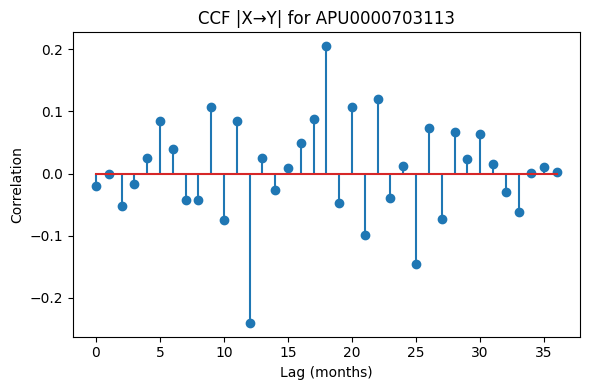

C:\Users\zhouz\AppData\Local\Temp\ipykernel_40152\3086765213.py:33: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(lags, ccf_vals, use_line_collection=True)


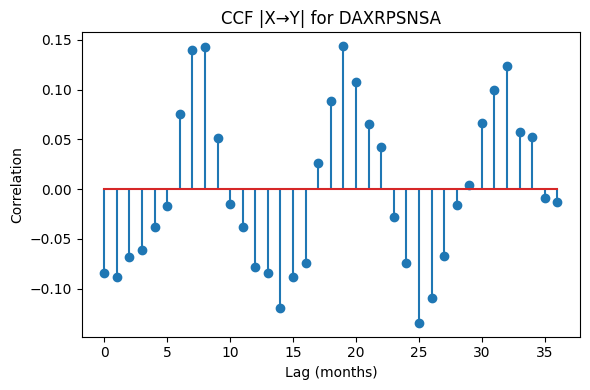

C:\Users\zhouz\AppData\Local\Temp\ipykernel_40152\3086765213.py:33: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(lags, ccf_vals, use_line_collection=True)


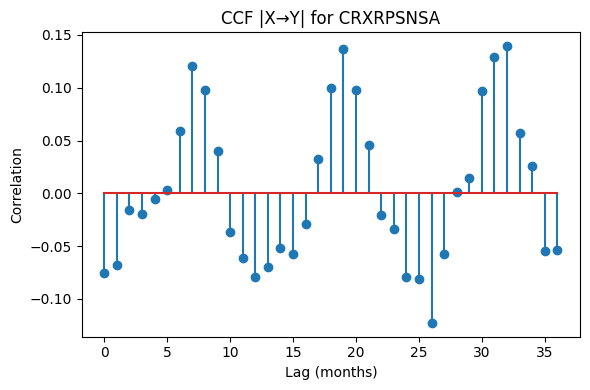

C:\Users\zhouz\AppData\Local\Temp\ipykernel_40152\3086765213.py:33: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(lags, ccf_vals, use_line_collection=True)


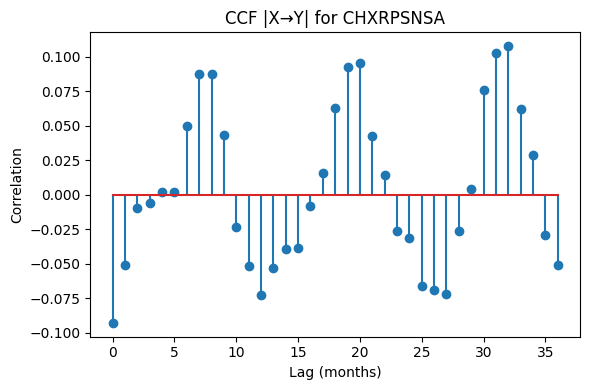

C:\Users\zhouz\AppData\Local\Temp\ipykernel_40152\3086765213.py:33: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(lags, ccf_vals, use_line_collection=True)


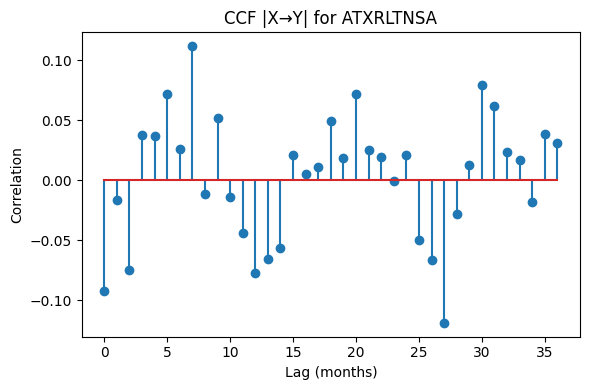

C:\Users\zhouz\AppData\Local\Temp\ipykernel_40152\3086765213.py:33: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(lags, ccf_vals, use_line_collection=True)


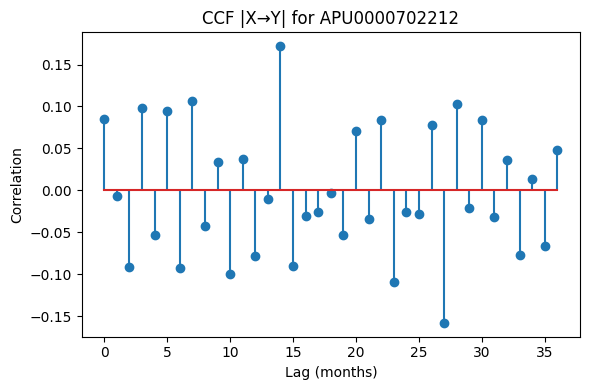

C:\Users\zhouz\AppData\Local\Temp\ipykernel_40152\3086765213.py:33: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(lags, ccf_vals, use_line_collection=True)


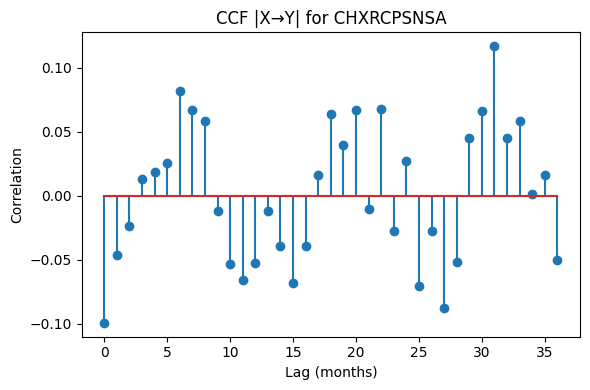

C:\Users\zhouz\AppData\Local\Temp\ipykernel_40152\3086765213.py:33: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(lags, ccf_vals, use_line_collection=True)


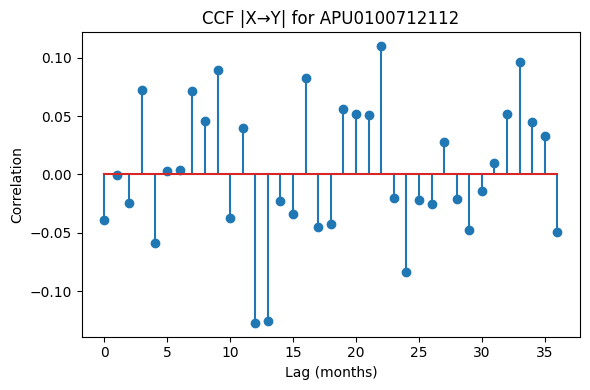

C:\Users\zhouz\AppData\Local\Temp\ipykernel_40152\3086765213.py:33: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(lags, ccf_vals, use_line_collection=True)


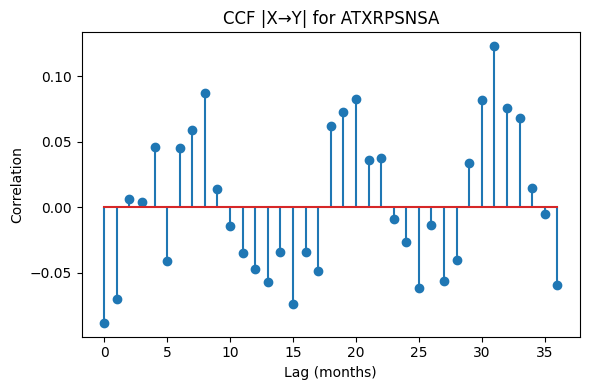

C:\Users\zhouz\AppData\Local\Temp\ipykernel_40152\3086765213.py:33: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(lags, ccf_vals, use_line_collection=True)


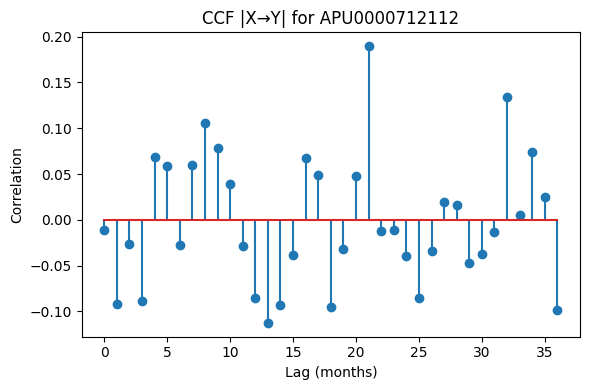

C:\Users\zhouz\AppData\Local\Temp\ipykernel_40152\3086765213.py:33: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(lags, ccf_vals, use_line_collection=True)


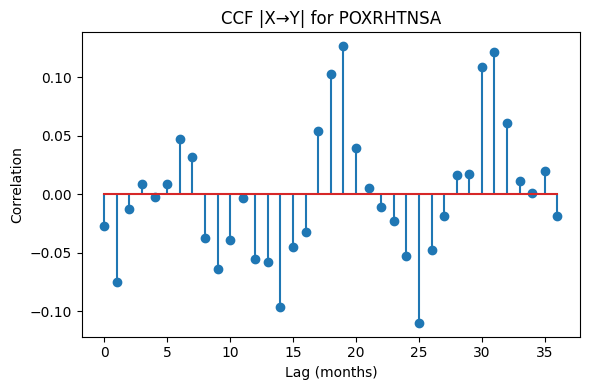

C:\Users\zhouz\AppData\Local\Temp\ipykernel_40152\3086765213.py:33: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(lags, ccf_vals, use_line_collection=True)


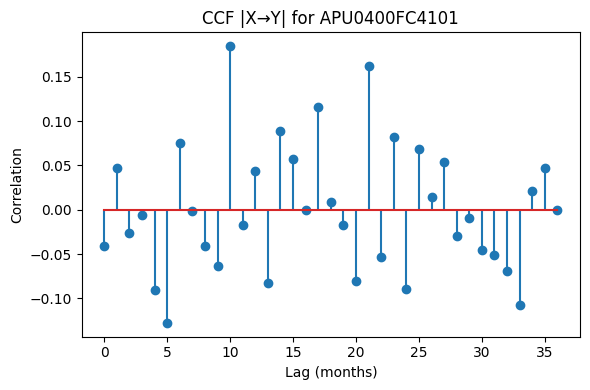

C:\Users\zhouz\AppData\Local\Temp\ipykernel_40152\3086765213.py:33: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(lags, ccf_vals, use_line_collection=True)


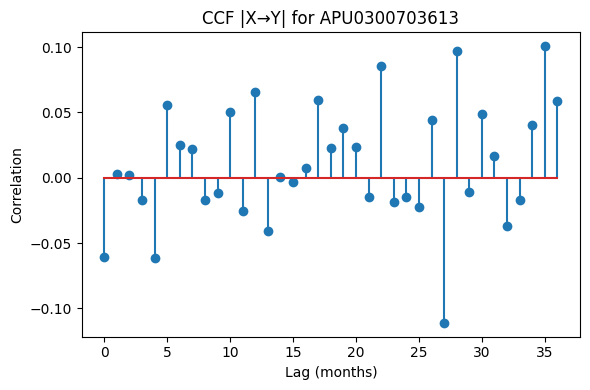

C:\Users\zhouz\AppData\Local\Temp\ipykernel_40152\3086765213.py:33: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(lags, ccf_vals, use_line_collection=True)


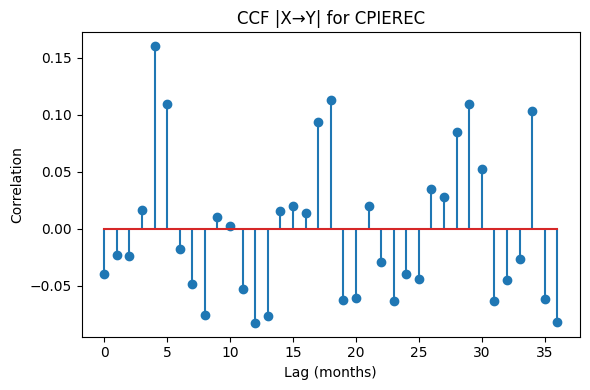

C:\Users\zhouz\AppData\Local\Temp\ipykernel_40152\3086765213.py:33: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(lags, ccf_vals, use_line_collection=True)


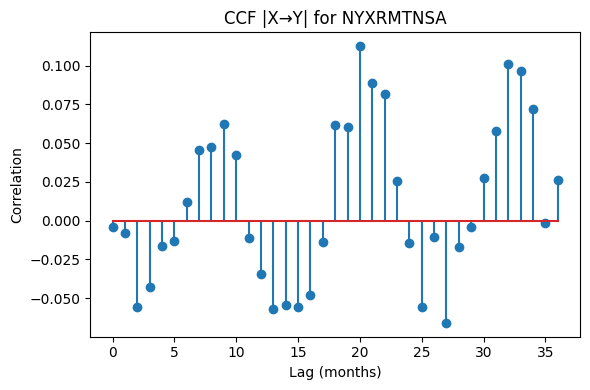

In [172]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

# -- Helper to enforce stationarity (first‐difference if needed) --
def is_stationary(s, signif=0.05):
    s_clean = s.dropna()
    if len(s_clean) < 10: return False
    return adfuller(s_clean, autolag='AIC')[1] < signif

def stationarize(s):
    s = pd.to_numeric(s, errors='coerce')
    return s if is_stationary(s) else s.diff()

# -- Parameters --
max_lag = 36
lags    = np.arange(0, max_lag+1)
top_feats = top15.index.tolist()   # your selected features

# -- Plot CCF for each of the top 15 features --
for feat in top_feats:
    x_s = stationarize(X[feat])
    y_s = stationarize(y)

    ccf_vals = []
    for lag in lags:
        ys = y_s.shift(lag)
        valid = x_s.notna() & ys.notna()
        xc, yc = x_s[valid].values, ys[valid].values
        ccf_vals.append(np.corrcoef(xc, yc)[0,1] if len(xc)>2 else np.nan)
    
    plt.figure(figsize=(6,4))
    plt.stem(lags, ccf_vals, use_line_collection=True)
    plt.title(f"CCF |X→Y| for {feat}")
    plt.xlabel("Lag (months)")
    plt.ylabel("Correlation")
    plt.tight_layout()
    plt.show()

In [148]:
# 1. Prepare the DataFrame
df = combined_df.copy()

# 2. Define target (endogenous) and exogenous regressors
y = df.iloc[:, 30]               # your loan-market risk metric
exog = df[top15.index.tolist()]  # the 15 selected macro indices

# 3. (Optional) Train/test split
# Here we train on everything up to end of 2022 and test on 2023 onward
train_end = '2022-12-01'
y_train, y_test   = y.loc[:train_end],   y.loc[train_end:]
exog_train, exog_test = exog.loc[:train_end], exog.loc[train_end:]
# 1) Coerce to numeric
y_train = pd.to_numeric(y_train, errors='coerce')
exog_train = exog_train.apply(pd.to_numeric, errors='coerce')

y_test  = pd.to_numeric(y_test,  errors='coerce')
exog_test  = exog_test.apply(pd.to_numeric, errors='coerce')

# 2) Drop any timestamps where either endog or any exog is NaN
train_idx = y_train.dropna().index
# also ensure all exog columns are non-null on these idx
train_idx = train_idx.intersection(exog_train.dropna(how='any').index)

y_train = y_train.loc[train_idx]
exog_train = exog_train.loc[train_idx]

# repeat for test if you plan to forecast
test_idx = y_test.dropna().index
test_idx = test_idx.intersection(exog_test.dropna(how='any').index)

y_test = y_test.loc[test_idx]
exog_test = exog_test.loc[test_idx]

In [179]:
import pmdarima as pm

# Fit auto‐ARIMA with exogenous regressors, seasonal cycle = 12 months
auto_model = pm.auto_arima(
    y_train,
    exogenous=exog_train,
    seasonal=True,
    m=12,
    trace=True,
    error_action='ignore',   # skip bad fits
    suppress_warnings=True,
    stepwise=True,           # faster search
    information_criterion='bic'
)

print(auto_model.summary())

# You can then extract best orders:
best_order = auto_model.order
best_seasonal_order = auto_model.seasonal_order
print("Best order:", best_order, "Seasonal order:", best_seasonal_order)

Performing stepwise search to minimize bic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : BIC=180.956, Time=0.67 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : BIC=160.408, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : BIC=156.812, Time=0.09 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : BIC=160.150, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[12]             : BIC=155.121, Time=0.02 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : BIC=165.582, Time=0.06 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : BIC=165.546, Time=0.06 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : BIC=168.851, Time=0.24 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : BIC=152.033, Time=0.02 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : BIC=156.662, Time=0.08 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.60 sec
 ARIMA(2,1,0)(0,0,0)[12] intercept   : BIC=153.336, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : BIC=151.291, Time=0.06 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : BIC=155.822, Time=0.14 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   

100%|████████████████████████████████████████████████████████████████████████████████| 105/105 [00:47<00:00,  2.22it/s]

Walk‐forward RMSE:  0.3480
Walk‐forward MAE:   0.2457
Walk‐forward MAPE: 98.42%
Walk‐forward R²:    0.8244


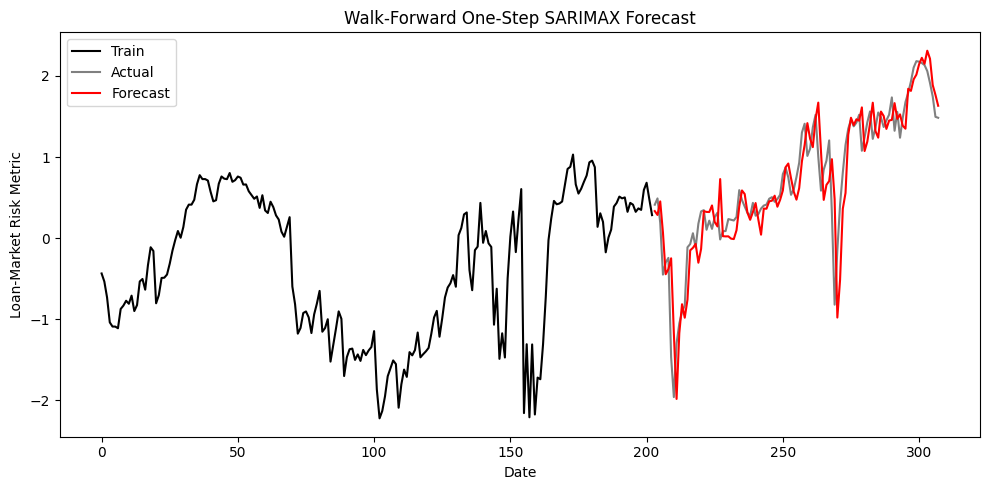

In [180]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# --- 1. Prepare data and parameters ---
df = combined_df.copy()
y_all    = df.iloc[:, 30]
exog_all = df[top15.index.tolist()]

# train/test split
train_end = '2023-06-01'
y_train, y_test       = y_all.loc[:train_end].copy(),    y_all.loc[train_end:].copy()
exog_train, exog_test = exog_all.loc[:train_end].copy(), exog_all.loc[train_end:].copy()
# 1) Coerce to numeric (invalid parses become NaN)
y_train = pd.to_numeric(y_train, errors='coerce').astype(float)
exog_train = exog_train.apply(pd.to_numeric, errors='coerce').astype(float)
y_test  = pd.to_numeric(y_test,  errors='coerce').astype(float)
exog_test  = exog_test.apply(pd.to_numeric, errors='coerce').astype(float)

# 2) Align & drop any rows with NaNs in endog or exog
common_idx = (
    y_train.dropna().index
    .intersection(exog_train.dropna(how='any').index)
)
y_train = y_train.loc[common_idx]
exog_train = exog_train.loc[common_idx]

common_idx = (
    y_test.dropna().index
    .intersection(exog_test.dropna(how='any').index)
)
y_test = y_test.loc[common_idx]
exog_test = exog_test.loc[common_idx]


order          = best_order          # from your auto-ARIMA/grid search
seasonal_order = best_seasonal_order

# Containers
history_y    = y_train.copy()
history_exog = exog_train.copy()
preds        = []

# --- 2. Walk-forward loop ---
for date in tqdm(y_test.index):
    # Fit SARIMAX on all data up to previous month
    mod = sm.tsa.SARIMAX(
        history_y,
        exog=history_exog,
        order=order,
        seasonal_order=seasonal_order,
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    res = mod.fit(disp=False)
    
    # Forecast one step ahead
    exog_future = exog_test.loc[[date]]
    yhat = res.forecast(steps=1, exog=exog_future)
    preds.append(yhat.iloc[0])
    
    # Append the true observation into history
    history_y.loc[date]    = y_test.loc[date]
    history_exog.loc[date] = exog_test.loc[date]

pred_series = pd.Series(preds, index=y_test.index)

# --- 3. Compute forecast errors ---
rmse = np.sqrt(mean_squared_error(y_test, pred_series))
mae  = mean_absolute_error(   y_test, pred_series)
mape = np.mean(np.abs((y_test - pred_series) / y_test)) * 100
r2   = r2_score(y_test, pred_series)

print(f"Walk‐forward RMSE:  {rmse:.4f}")
print(f"Walk‐forward MAE:   {mae :.4f}")
print(f"Walk‐forward MAPE: {mape:.2f}%")
print(f"Walk‐forward R²:    {r2:.4f}")

# --- 4. Plot results ---
plt.figure(figsize=(10,5))
plt.plot(y_train.index,     y_train,     label='Train',   color='black')
plt.plot(y_test.index,      y_test,      label='Actual',  color='gray')
plt.plot(pred_series.index, pred_series, label='Forecast',color='red')
plt.legend(loc='upper left')
plt.title('Walk-Forward One-Step SARIMAX Forecast')
plt.ylabel('Loan-Market Risk Metric')
plt.xlabel('Date')
plt.tight_layout()
plt.show()

100%|████████████████████████████████████████████████████████████████████████████████| 105/105 [00:47<00:00,  2.23it/s]

Random 15-feature forecast metrics:
RMSE:  0.3423
MAE:   0.2470
MAPE: 81.20%
R²:    0.8301


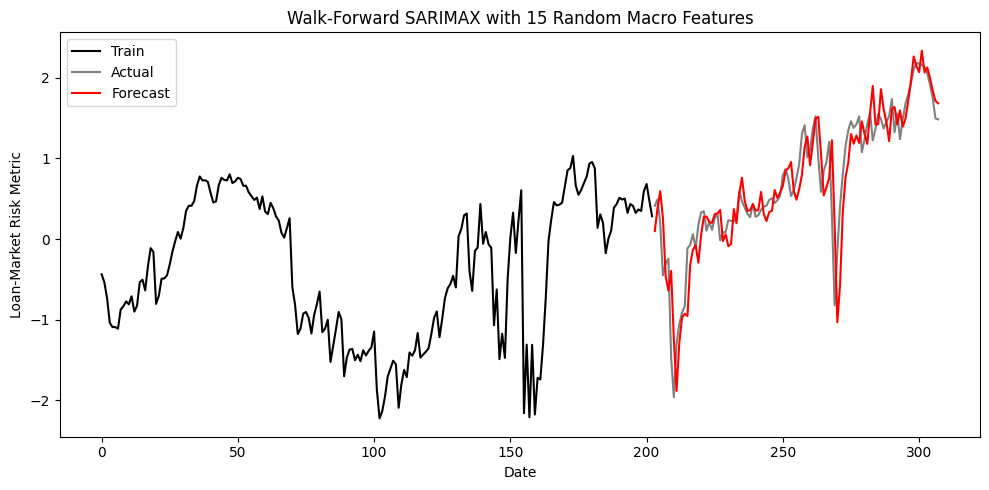

In [181]:
import random
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# 1) Randomly pick 15 features
random.seed(1307)
all_features = list(X.columns)
sampled_feats = random.sample(all_features, 15)

# 2) Prepare endogenous and exogenous data
df = combined_df.copy()

y_all    = df.iloc[:, 30]
exog_all = df[sampled_feats]

# 3) Train/test split
train_end     = '2022-12-01'
y_train       = y_all.loc[:train_end].astype(float)
y_test        = y_all.loc[train_end:].astype(float)
exog_train    = exog_all.loc[:train_end].apply(pd.to_numeric, errors='coerce').astype(float)
exog_test     = exog_all.loc[train_end:].apply(pd.to_numeric, errors='coerce').astype(float)

# align & drop NaNs
train_idx = y_train.dropna().index.intersection(exog_train.dropna(how='any').index)
y_train   = y_train.loc[train_idx]
exog_train= exog_train.loc[train_idx]

test_idx  = y_test.dropna().index.intersection(exog_test.dropna(how='any').index)
y_test    = y_test.loc[test_idx]
exog_test = exog_test.loc[test_idx]

# 4) Walk-forward one-step SARIMAX forecasting
order          = best_order           # from your auto-ARIMA/grid search
seasonal_order = best_seasonal_order

history_y    = y_train.copy()
history_exog = exog_train.copy()
preds        = []

for date in tqdm(y_test.index):
    mod = sm.tsa.SARIMAX(
        history_y,
        exog=history_exog,
        order=order,
        seasonal_order=seasonal_order,
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    res = mod.fit(disp=False)

    # forecast next step
    x_future = exog_test.loc[[date]]
    yhat = res.forecast(steps=1, exog=x_future)
    preds.append(yhat.iloc[0])

    # append actual to history
    history_y.loc[date]    = y_test.loc[date]
    history_exog.loc[date] = exog_test.loc[date]

pred_series = pd.Series(preds, index=y_test.index)

# 5) Compute metrics
rmse = np.sqrt(mean_squared_error(y_test, pred_series))
mae  = mean_absolute_error(   y_test, pred_series)
mape = np.mean(np.abs((y_test - pred_series) / y_test)) * 100
r2   = r2_score(y_test, pred_series)

print("Random 15-feature forecast metrics:")
print(f"RMSE:  {rmse:.4f}")
print(f"MAE:   {mae :.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²:    {r2:.4f}")

# 6) (Optional) Plot actual vs forecast
plt.figure(figsize=(10,5))
plt.plot(y_train.index,     y_train,     label='Train',   color='black')
plt.plot(y_test.index,      y_test,      label='Actual',  color='gray')
plt.plot(pred_series.index, pred_series, label='Forecast',color='red')
plt.legend()
plt.title('Walk-Forward SARIMAX with 15 Random Macro Features')
plt.xlabel('Date')
plt.ylabel('Loan-Market Risk Metric')
plt.tight_layout()
plt.show()